# Noise Reduction with NMF
Noise reduction experiment with non-negative matrix factrization (NMF).

In [1]:
import IPython.display
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
""" Basic I/O """
import soundfile as sf
import wave


def load_audio_sf(file_path):
    signal, frame_rate = sf.read(file_path)
    wave_file = wave.open(file_path, 'r')
    return signal, frame_rate, wave_file.getsampwidth()

def export_audio_sf(file_path, wave, frame_rate):
    sf.write(file_path, wave, frame_rate)

In [84]:
""" Non-negative Matric Factrization (NMF) """
import logging
from typing import List

import numpy as np
import librosa

logging.basicConfig(format='%(asctime)s %(levelname)-8s %(message)s', level=logging.INFO, datefmt='%Y-%m-%d %H:%M:%S')

EPS = np.spacing(1)


def euclid_divergence(y, yh):
    return 1 / 2 * (y ** 2 + yh ** 2 - 2 * y * yh).sum()


def kl_divergence(y, yh):
    return ((y * np.log(y / (yh + EPS))) - y + yh + EPS).sum()


def nmf(y,
        r: int = 20,
        n_iter: int = 50,
        div: str = "kl",
        basis_h: (List, np.array) = None,
        init_h: (List, np.array) = None,
        init_u: (List, np.array) = None,
        display_log: bool = False):
    """ decompose non-negative matrix to components and activation with NMF

    y ≈　HU
    y ∈ r (m, n)
    h ∈ r (m, k)
    HU ∈ r (k, n)

     Parameter
    ----------------
    y: numpy.array
        target matrix to decompose
    r: int
        number of bases to decompose
    n_iter: int
        number for executing objective function to optimize
    div: str
        define divergence "kl" or "euc"
    init_h:
        initial value of h matrix. default value is random matrix
    init_u:
        initial value of u matrix. default value is random matrix

     Return
    ----------------
    Array of:
    0: matrix of h
    1: matrix of u
    2: array of cost transition
    """

    # size of input spectrogram
    assert np.ndim(y) == 2
    m, n = y.shape

    # initialization
    u = np.random.rand(r, n) if init_u is None else np.array(init_u)
    h = np.random.rand(m, r) if init_h is None else np.array(init_h)

    # reflect basis h
    if basis_h is None:
        fix_index = 0
    else:
        fix_index = np.array(basis_h).shape[1]
        assert fix_index < h.shape[1], "Over Size: {} > {}".format(fix_index, h.shape[1])
        h[0:, 0:fix_index] = basis_h

    # array to save the value of the euclid divergence
    cost = np.zeros(n_iter)

    # computation of lam (estimate of y)
    lam = np.dot(h, u)

    # iterative computation
    for i in range(n_iter):
        if div == "euc":
            # compute euclid divergence
            cost[i] = euclid_divergence(y, lam)
            # update h
            h *= np.dot(y, u.T) / (np.dot(np.dot(h, u), u.T) + EPS)
            if fix_index > 0:
                h[0:, 0:fix_index] = basis_h
            # update u
            u *= np.dot(h.T, y) / (np.dot(np.dot(h.T, h), u) + EPS)
        elif div == "kl":
            # compute euclid divergence
            cost[i] = kl_divergence(y, lam)
            # update h
            numerator_h = np.dot((y / (np.dot(h, u) + EPS)), u.T)
            denominator_h = np.tile(u.sum(axis=1), (m, 1))
            h *= numerator_h / (denominator_h + EPS)
            if fix_index > 0:
                h[0:, 0:fix_index] = basis_h
            # update u
            numerator_u = np.dot(h.T, (y / (np.dot(h, u) + EPS)))
            denominator_u = np.tile(h.sum(axis=0), (n, 1))
            u *= numerator_u / (denominator_u.T + EPS)
        else:
            raise ValueError('unknown divergence: {}'.format(div))
        # recomputation of lam
        lam = np.dot(h, u)
        if display_log:
            logging.info('nmf: iter {}: loss {}'.format(i, cost[i]))
    return [h, u, cost]


def nmf_filter(y_o: List,
               y_n: List = None,
               n_iter: int = 50,
               div: str = "kl",
               normalize_scale: float = 2,
               frame_rate: int = None,
               basis_noise_num: int = 20,
               basis_num: int = 20):
    """ NMF based noise reduction filter

     Parameter
    -----------
    y_o: List
        1-d raw signal
    y_n: List
        1-d noise reference signal
    n_iter: int
        optimization steps at NMF
    div: str
        divergence for NMF, `kl` or `euc`
    normalize_scale: int
        after NMF denoising, the signal is normalized to avoid having excessive volume by
            norm = max(denoised_signal) / (normalize_scale * max(y_o))
            denoised_signal = denoised_signal / norm
    """

    if y_n is None:
        if frame_rate is None:
            y_n = y_o[:int(len(y_o) / 10)]
        else:
            y_n = y_o[:int(frame_rate * 0.8)]
    max_amp = np.abs(y_o).max()

    nmf_shared = {'n_iter': n_iter, 'div': div}
    # training
    logging.info('nmf on noise reference')
    y_n = librosa.stft(y_n)
    h_n, u_n, _ = nmf(np.abs(y_n), r=basis_noise_num, **nmf_shared)

    # separation
    logging.info('nmf on source signal')
    y_o = librosa.stft(y_o)
    h_o, u_o, _ = nmf(np.abs(y_o), r=basis_noise_num + basis_num, basis_h=h_n, **nmf_shared)

    # wiener filter
    y_est = np.dot(h_o, u_o)
    y_target = np.dot(h_o[0:, basis_noise_num:basis_noise_num + basis_num],
                      u_o[basis_noise_num:basis_noise_num + basis_num, 0:])

    # smoothing
    y_mask = y_target / (y_est + EPS)

    y_sep = np.abs(y_o) ** 2 * y_mask
    y_phase = np.cos(np.angle(y_o) + 1j * np.sin(np.angle(y_o)))
    y_denoised = librosa.istft(y_sep * y_phase)
    y_denoised_normalize = y_denoised / np.max(y_denoised) * (max_amp * normalize_scale)
    return y_denoised_normalize


In [57]:
def plot(signal_denoised, signal, frame_rate):
    plt.figure(0, figsize=(6, 4))
    plt.plot(signal_denoised)
    plt.plot(signal)
    plt.legend(['reduced', 'source'])
    plt.grid()

    interval = 10
    length_sec = int(len(signal)/frame_rate) + 1
    interval = min(10, length_sec)
    ind_1 = np.arange(0, length_sec+1, int(length_sec/interval))
    ind_2 = ind_1 * frame_rate
    plt.title('Nose reduction')
    plt.xticks(ind_2, ind_1)
    plt.xlim([0, len(signal)])
    plt.xlabel("Time (sec.): total %0.2f" % (len(signal)/frame_rate))
    plt.ylabel("Amplitude")
    plt.show()

## Experiment

In [64]:
audio_file = '../../sample_data/vc_6.wav'
signal, frame_rate, _ = load_audio_sf(audio_file)
IPython.display.Audio(audio_file)

2021-01-03 18:56:32 INFO     nmf on noise reference
2021-01-03 18:56:32 INFO     nmf on source signal


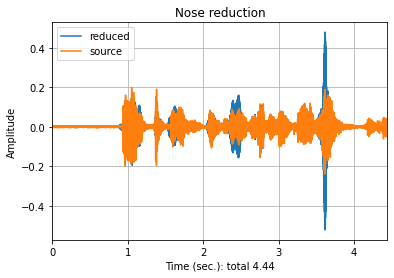

In [89]:
# apply on mono audio (we set first 2 seconds as a noise referrence)
noise_ref = signal[0:int(frame_rate / 2)]
signal_denoised = nmf_filter(signal,
                             noise_ref,
                             div = "kl",
                             basis_noise_num = 20,
                             basis_num = 20)

# plot
plot(signal_denoised, signal, frame_rate)


# write to file 
export_file = audio_file.replace('.wav', '_nmf.wav')
export_audio_sf(export_file, signal_denoised, frame_rate)
IPython.display.Audio(export_file)